In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shutil
import imutils
import shutil
import itertools

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


2025-04-13 18:36:33.287947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744569393.510079      32 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744569393.575186      32 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Creamos carpetas si no existen
for split in ['TRAIN', 'VAL', 'TEST']:
    for category in ['YES', 'NO']:
        os.makedirs(f"{split}/{category}", exist_ok=True)

# Verificamos que se hayan creado
for root, dirs, files in os.walk(".", topdown=True):
    for name in dirs:
        print(os.path.join(root, name))

./VAL
./TEST
./.virtual_documents
./TRAIN
./VAL/NO
./VAL/YES
./TEST/NO
./TEST/YES
./TRAIN/NO
./TRAIN/YES


In [4]:

IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/'

# Repartimos las imágenes en train/test/val
for CLASS in os.listdir(IMG_PATH):
    if os.path.isdir(os.path.join(IMG_PATH, CLASS)) and CLASS in ['yes', 'no']:
        print(f"\nProcesando clase: {CLASS}")

        full_class_path = os.path.join(IMG_PATH, CLASS)
        images = os.listdir(full_class_path)
        IMG_NUM = len(images)
        print(f"Número de imágenes: {IMG_NUM}")

        for n, FILE_NAME in enumerate(images):
            img = os.path.join(full_class_path, FILE_NAME)
            
            if n < 5:
                dest = f'TEST/{CLASS.upper()}/{FILE_NAME}'
                print("→ TO TEST:", dest)
            elif n < 0.8 * IMG_NUM:
                dest = f'TRAIN/{CLASS.upper()}/{FILE_NAME}'
                print("→ TO TRAIN:", dest)
            else:
                dest = f'VAL/{CLASS.upper()}/{FILE_NAME}'
                print("→ TO VAL:", dest)
            
            shutil.copy(img, dest)



Procesando clase: no
Número de imágenes: 98
→ TO TEST: TEST/NO/34 no.jpg
→ TO TEST: TEST/NO/N20.JPG
→ TO TEST: TEST/NO/N1.JPG
→ TO TEST: TEST/NO/49 no.jpg
→ TO TEST: TEST/NO/N15.jpg
→ TO TRAIN: TRAIN/NO/No18.jpg
→ TO TRAIN: TRAIN/NO/31 no.jpg
→ TO TRAIN: TRAIN/NO/no 6.jpg
→ TO TRAIN: TRAIN/NO/3 no.jpg
→ TO TRAIN: TRAIN/NO/no 5.jpeg
→ TO TRAIN: TRAIN/NO/no 1.jpg
→ TO TRAIN: TRAIN/NO/26 no.jpg
→ TO TRAIN: TRAIN/NO/N26.JPG
→ TO TRAIN: TRAIN/NO/N5.jpg
→ TO TRAIN: TRAIN/NO/6 no.jpg
→ TO TRAIN: TRAIN/NO/No21.jpg
→ TO TRAIN: TRAIN/NO/17 no.jpg
→ TO TRAIN: TRAIN/NO/No22.jpg
→ TO TRAIN: TRAIN/NO/29 no.jpg
→ TO TRAIN: TRAIN/NO/46 no.jpg
→ TO TRAIN: TRAIN/NO/32 no.jpg
→ TO TRAIN: TRAIN/NO/42 no.jpg
→ TO TRAIN: TRAIN/NO/no 90.jpg
→ TO TRAIN: TRAIN/NO/no 94.jpg
→ TO TRAIN: TRAIN/NO/No19.jpg
→ TO TRAIN: TRAIN/NO/47 no.jpg
→ TO TRAIN: TRAIN/NO/N22.JPG
→ TO TRAIN: TRAIN/NO/No12.jpg
→ TO TRAIN: TRAIN/NO/15 no.jpg
→ TO TRAIN: TRAIN/NO/20 no.jpg
→ TO TRAIN: TRAIN/NO/No13.jpg
→ TO TRAIN: TRAIN/NO/11 no.j

In [5]:
def load_data(directory, img_size):
    data = []
    labels = []
    label_names = ['NO', 'YES']  

    for label in label_names:
        folder_path = os.path.join(directory, label)
        for img_name in tqdm(os.listdir(folder_path), desc=f"Cargando {label} desde {directory}"):
            img_path = os.path.join(folder_path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                img = img / 255.0
                data.append(img)
                labels.append(1 if label == 'YES' else 0)
            except Exception as e:
                print(f"No se pudo cargar {img_path}. Error: {e}")

    data = np.array(data)
    labels = np.array(labels)

    return data, labels, label_names


In [6]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224, 224)

# Cargamos cada uno de los conjuntos de imágenes
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


Cargando YES desde VAL/: 100%|██████████| 31/31 [00:00<00:00, 372.05it/s]


In [7]:
def load_data(dir_path, img_size=(100, 100)):
    X = []
    y = []
    labels = dict()
    i = 0

    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img_path = os.path.join(dir_path, path, file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size)  # aquí sí
                    X.append(img)
                    y.append(i)
            i += 1

    X = np.array(X, dtype=object)
    y = np.array(y)
    print(f'{len(X)} imagenes cargadas desde: {dir_path}')
    return X, y, labels


In [8]:
def plot_samples(images, labels, label_names, num_samples=30):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(5, 6, i + 1)
        plt.imshow(images[i])
        plt.title(label_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


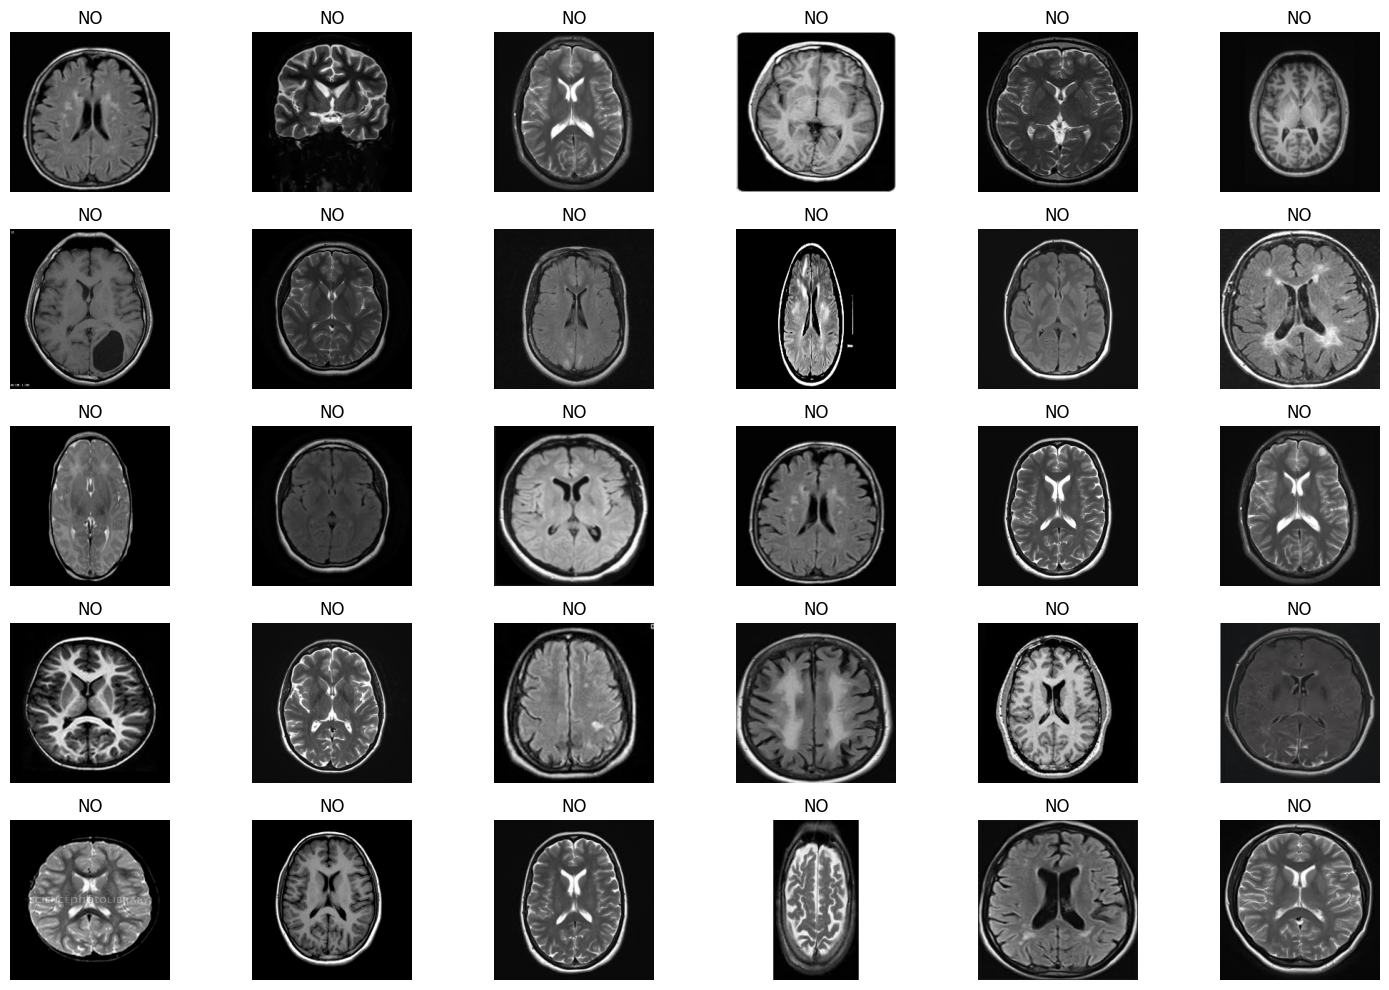

In [9]:
plot_samples(X_train, y_train, labels, 30)


In [10]:
def crop_imgs(set_name, add_pixels_value=0):

    set_new = []

    for img in set_name:
        img = (img * 255).astype("uint8")
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # aplica un umbral a la imagen, luego erosiona y dilata para limpiar ruido
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # encuentra contornos, usa el más grande
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        c = max(cnts, key=cv2.contourArea)

        # encuentra los puntos extremos
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,
                      extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        set_new.append(new_img)

    return np.array(set_new, dtype=object)


In [11]:
# Aplica el recorte a cada conjunto
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

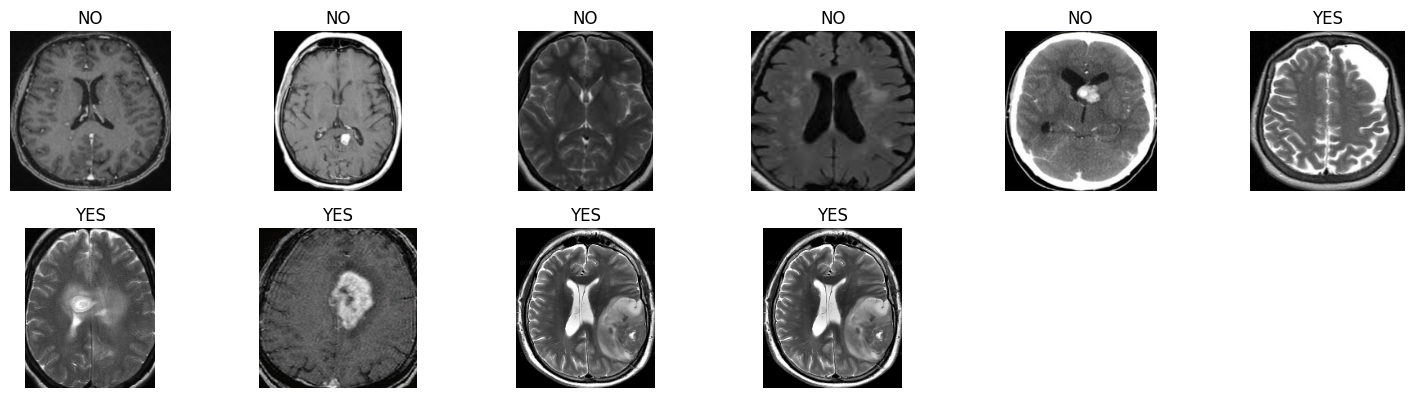

In [12]:
plot_samples(X_test_crop, y_test, labels, 10)  # no más de 10

In [19]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name + 'NO/' + str(i) + '.jpg', img)
        else:
            cv2.imwrite(folder_name + 'YES/' + str(i) + '.jpg', img)
        i += 1


In [20]:
# Creamos las carpetas donde guardaremos las imágenes
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES 
!mkdir TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO
!mkdir VAL_CROP/YES VAL_CROP/NO

# Guardamos las imágenes que recortamos en las carpetas anteriores
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')


mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [21]:
def preprocess_imgs(set_name, img_size):
    """
    Resiza y aplica preprocesamiento VGG-16
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)


In [22]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)


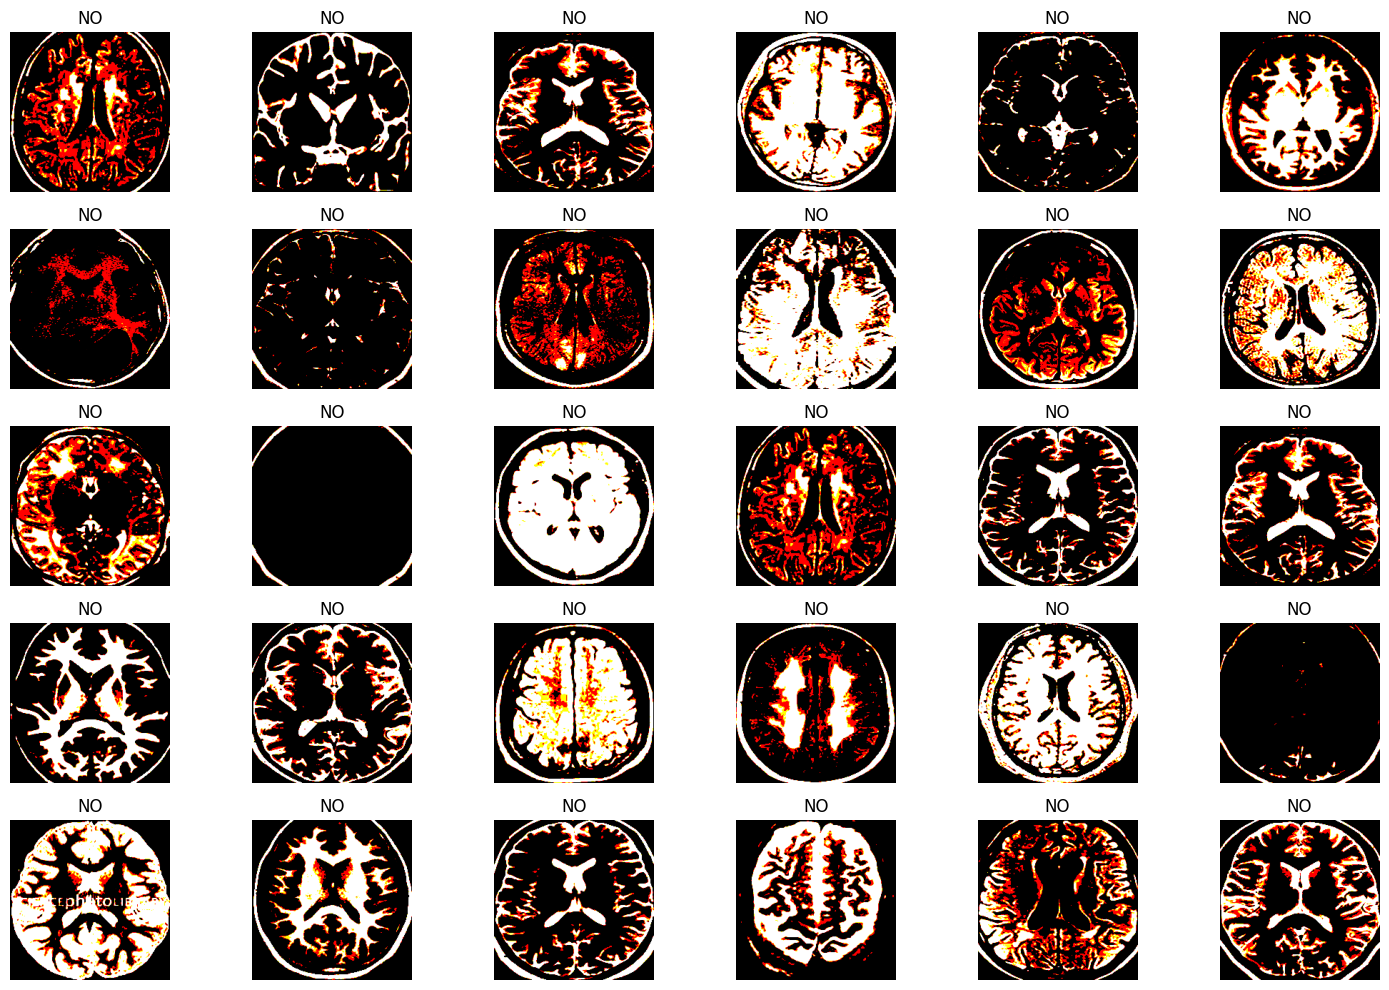

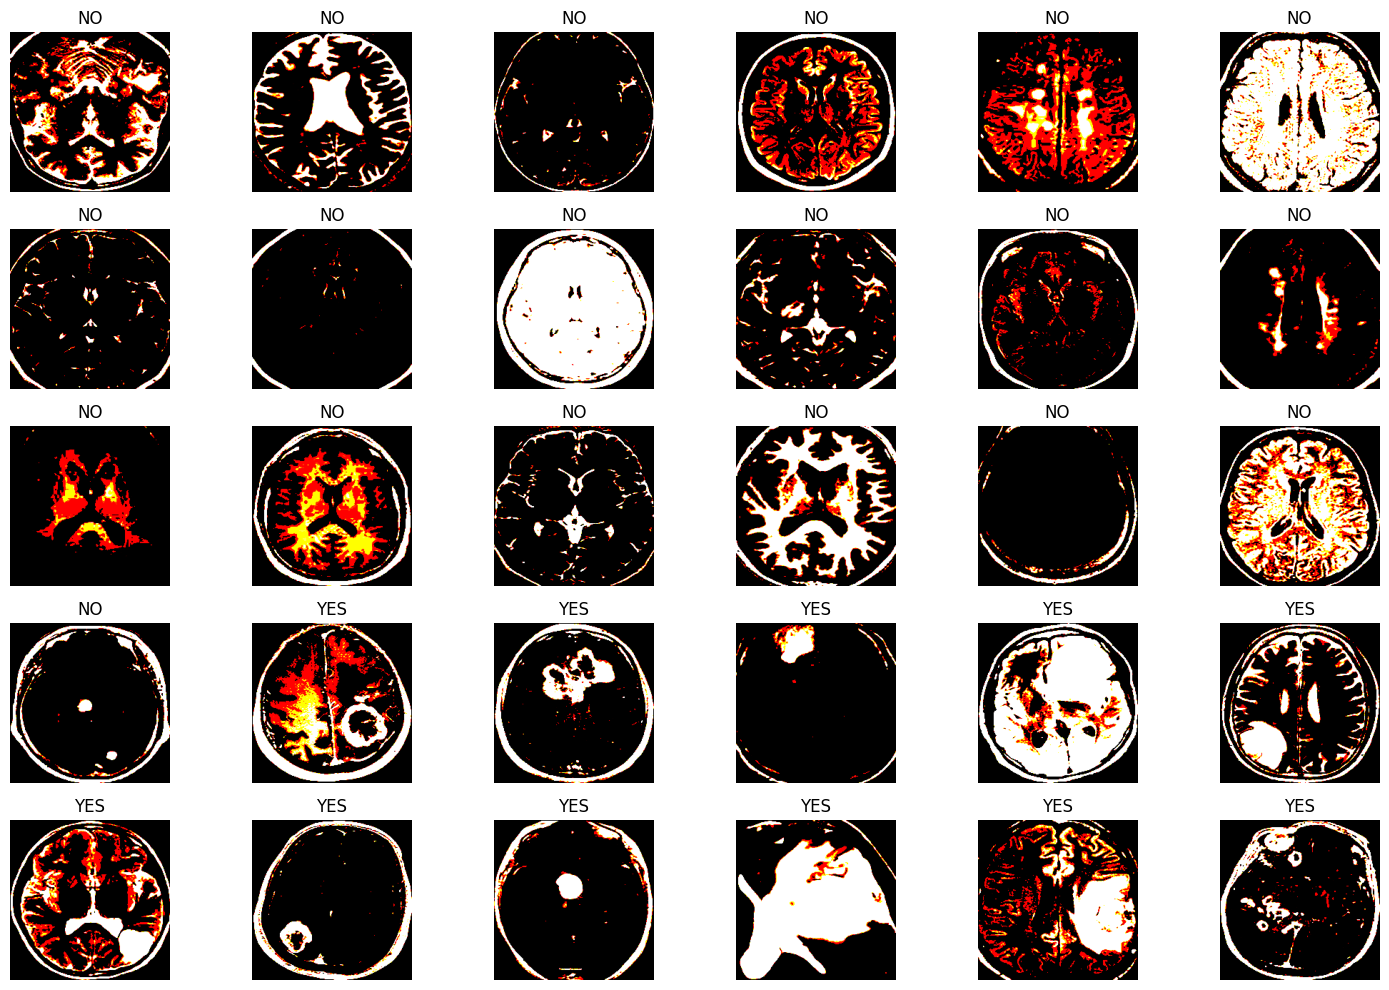

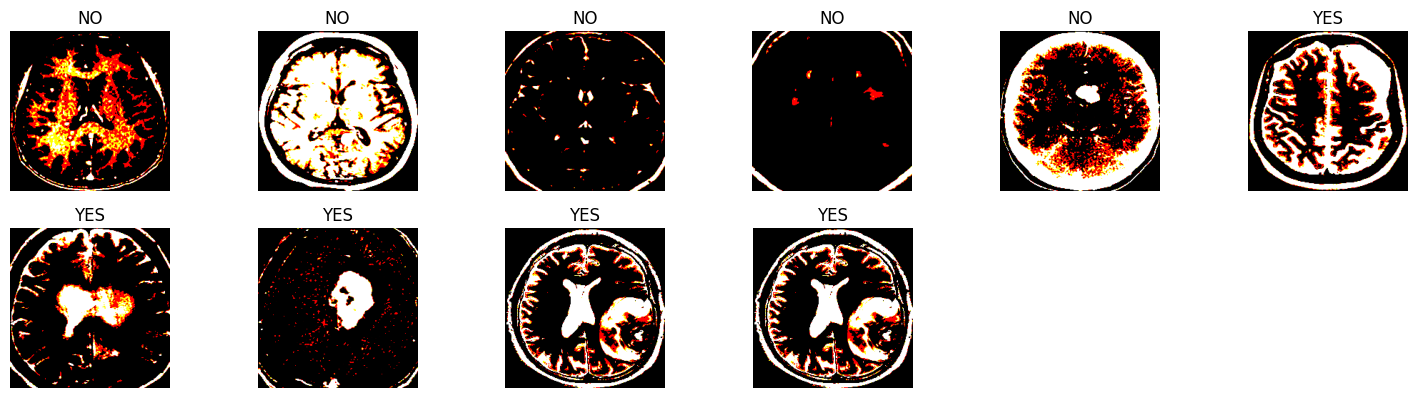

In [23]:
# Visualización de imágenes ya preprocesadas
plot_samples(X_train_prep, y_train, labels, min(30, len(X_train_prep)))
plot_samples(X_val_prep, y_val, labels, min(30, len(X_val_prep)))
plot_samples(X_test_prep, y_test, labels, min(30, len(X_test_prep)))

In [26]:

# Directorios con imágenes recortadas
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42  


# Generadores con aumento de datos
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

# Cargar el modelo base
base_model = VGG16(
    weights=None,
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

base_model.load_weights("/kaggle/input/vgg16weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

# Definir el modelo secuencial
NUM_CLASSES = 1
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
model.layers[0].trainable = False  # Congelar el modelo base

# Compilación
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()


2025-04-13 18:39:11.602424: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
EPOCHS = 15
batch_size = 32
val_batch_size = 16

es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6,
    restore_best_weights=True)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[es]
)


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 63s 9s/step - accuracy: 0.6706 - loss: 3.0554 - val_accuracy: 0.7400 - val_loss: 1.5746
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/15


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - accuracy: 0.6588 - loss: 3.4690 - val_accuracy: 0.7400 - val_loss: 1.5689
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 63s 9s/step - accuracy: 0.7046 - loss: 3.2270 - val_accuracy: 0.7800 - val_loss: 1.5503
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 63s 9s/step - accuracy: 0.7458 - loss: 2.1694 - val_accuracy: 0.7400 - val_loss: 1.7218
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 63s 9s/step - accuracy: 0.6994 - loss: 2.7708 - val_accuracy: 0.7800 - val_loss: 1.6309
Epoch 10/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 63s 9s/step - accuracy: 0.6723 - loss: 2.8185 - val_accuracy: 0.7600 - val_loss: 1.5202
Epoch 12/15
7/7 ━━━━━━━━━━━━━━

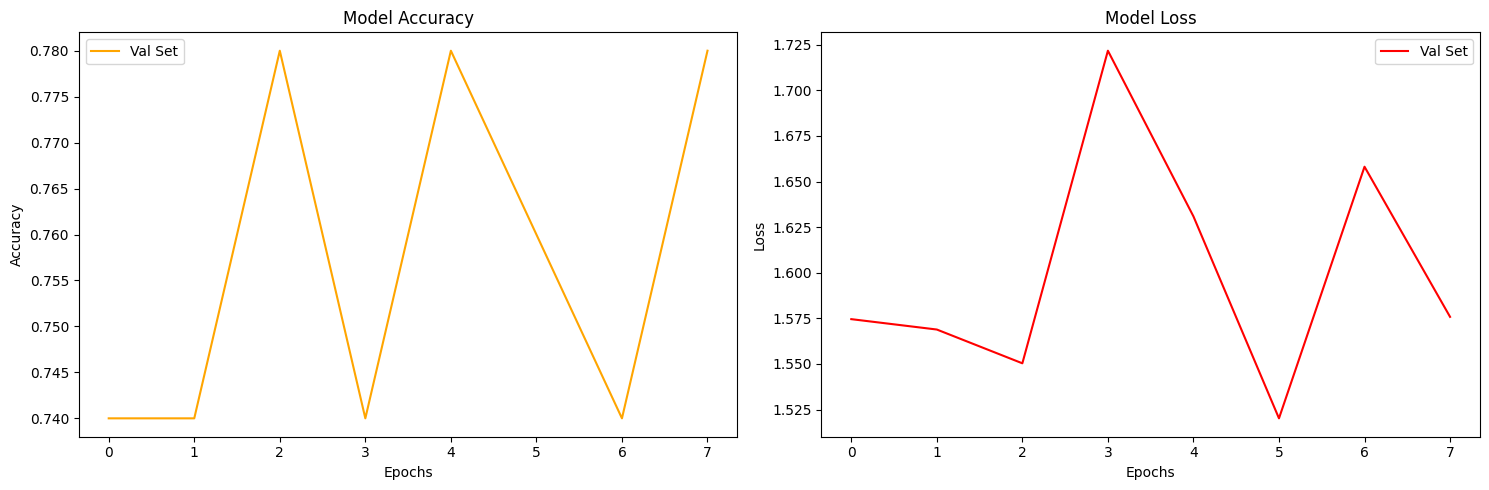

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [44]:
# plot model performance
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_range = range(len(val_acc))

plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, val_acc, label='Val Set', color='orange')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Set', color='red')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()
print(history.history.keys())


In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    class_names = [label[1] for label in classes]  # conversión de: [(0, 'NO'), (1, 'YES')] -> ['NO', 'YES']
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalizar')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step
Val Accuracy = 0.78
Matriz de confusión sin normalizar
[[13  6]
 [ 5 26]]


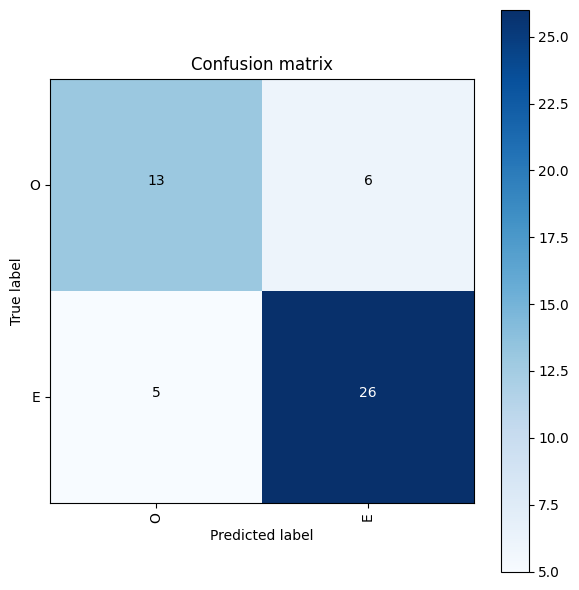

In [66]:

# Predicción sobre el conjunto de validación
predictions = model.predict(X_val_prep)
predictions = [1 if x > 0.49 else 0 for x in predictions]

# Cálculo de la precisión
accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

# Matriz de confusión
confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes=labels, normalize=False)


### Hemos usado el modelo VGG16 preentrenado con ImageNet. Como resultado, el modelo alcanzó un 78% de precisión al ajustar el umbral en 0.49. Sin embargo aún no llegamos al 80% deseado. En el futuro podrían probarse otras arquitecturas o hacer fine-tuning para mejorar la precisión.